In [2568]:
import pandas as pd
import numpy as np
import surprise as sp
import json
import os
import opendatasets as od
import re
import ast
from implicit.nearest_neighbours import BM25Recommender
from implicit.als import AlternatingLeastSquares
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Movie 

In [1157]:
rating = pd.read_csv("datasets/movie dataset/ratings.csv")
rating

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


In [1186]:
movies_metadata = pd.read_csv("datasets/movie dataset/movies_metadata.csv", low_memory=True)
movies_metadata = movies_metadata[~movies_metadata.id.str.contains("-")]
movies_metadata=movies_metadata[~movies_metadata['title'].isnull()]
movies_metadata['id'] = movies_metadata['id'].astype(int)
movies_metadata.columns

<ipython-input-1186-a78f9aca8e1b>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv("datasets/movie dataset/movies_metadata.csv", low_memory=True)


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [1187]:
links = pd.read_csv("datasets/movie dataset/links.csv", low_memory=True)
links.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

In [1188]:
movies_metadata = movies_metadata[['id','title', 'genres','release_date','overview', 'adult','vote_average', 'vote_count']]
movies_metadata

,id,title,genres,release_date,overview,adult,vote_average,vote_count
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995-10-30,"Led by Woody, Andy's toys live happily in his ...",False,7.7,5415.0
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995-12-15,When siblings Judy and Peter discover an encha...,False,6.9,2413.0
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995-12-22,A family wedding reignites the ancient feud be...,False,6.5,92.0
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-12-22,"Cheated on, mistreated and stepped on, the wom...",False,6.1,34.0
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",1995-02-10,Just when George Banks has recovered from his ...,False,5.7,173.0
...,...,...,...,...,...,...,...,...
45461,439050,Subdue,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",NaN,Rising and falling between a man and woman.,False,4.0,1.0
45462,111109,Century of Birthing,"[{'id': 18, 'name': 'Drama'}]",2011-11-17,An artist struggles to finish his work while a...,False,9.0,3.0
45463,67758,Betrayal,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",2003-08-01,"When one of her hits goes wrong, a professiona...",False,3.8,6.0
45464,227506,Satan Triumphant,[],1917-10-21,"In a small town live two brothers, one a minis...",False,0.0,0.0


In [1190]:
movies = pd.merge(movies_metadata, links, how="left", left_on='id', right_on='tmdbId')[['movieId','id','title','genres','release_date','adult','overview','vote_average','vote_count']]

In [1191]:
movies['genres'].replace({"\'": "\""}, regex=True)
temp = pd.json_normalize((movies['genres'].replace({"\'": "\""}, regex=True)).apply(json.loads))

In [1192]:
# turn array of genre dicts into concat str
for column in temp.columns:
    temp[column] = temp[column].apply(lambda x: x['name'] if x is not None else "")
temp['genres'] = temp.agg('|'.join, axis=1)
temp['genres'] = temp['genres'].apply(lambda x: x.rstrip('|'))

In [1193]:
movies['genres'] = temp['genres']
movies = movies.set_index('movieId')
movies = movies[~movies.duplicated()]
del temp

In [1165]:
data = csr_matrix((rating.rating.values.astype('f8'),
                   (rating.userId.values,rating.movieId.values)
                  ))

In [1166]:
_, S, V = svds(data, k=150, return_singular_vectors='vh')

In [1167]:
movies[movies.title.str.contains('Inception',flags=2,na=False)]

,id,title,genres,release_date,adult,overview,vote_average,vote_count
movieId,,,,,,,,
79132,27205,Inception,Action|Thriller|Science Fiction|Mystery|Adventure,2010-07-14,False,"Cobb, a skilled thief who commits corporate es...",8.1,14075.0


In [271]:
movies[('Face/Off' == movies['title']) | ('The Rock' == movies['title'])]

,title,genres,release_date,overview,vote_average,vote_count
movieId,,,,,,
733,The Rock,Drama|Comedy|War,1996-06-06,A group of renegade marine commandos seizes a ...,6.9,1474.0
1573,Face/Off,Drama|Action|Thriller|Crime,1997-06-27,An antiterrorism agent goes under the knife to...,6.8,1612.0


In [1169]:
movies.loc[np.argsort(-V.T @ V[:, [79132]].sum(axis=1))[:10]]

,id,title,genres,release_date,adult,overview,vote_average,vote_count
movieId,,,,,,,,
79132,27205,Inception,Action|Thriller|Science Fiction|Mystery|Adventure,2010-07-14,False,"Cobb, a skilled thief who commits corporate es...",8.1,14075.0
74458,11324,Shutter Island,Drama|Thriller|Mystery,2010-02-18,False,World War II soldier-turned-U.S. Marshal Teddy...,7.8,6559.0
58559,155,The Dark Knight,Drama|Action|Crime|Thriller,2008-07-16,False,Batman raises the stakes in his war on crime. ...,8.3,12269.0
109487,157336,Interstellar,Adventure|Drama|Science Fiction,2014-11-05,False,Interstellar chronicles the adventures of a gr...,8.1,11187.0
72998,19995,Avatar,Action|Adventure|Fantasy|Science Fiction,2009-12-10,False,"In the 22nd century, a paraplegic Marine is di...",7.2,12114.0
68157,16869,Inglourious Basterds,Drama|Action|Thriller|War,2009-08-18,False,"In Nazi-occupied France during World War II, a...",7.9,6598.0
91529,49026,The Dark Knight Rises,Action|Crime|Drama|Thriller,2012-07-16,False,Following the death of District Attorney Harve...,7.6,9263.0
2571,603,The Matrix,Action|Science Fiction,1999-03-30,False,"Set in the 22nd century, The Matrix tells the ...",7.9,9079.0
99114,68718,Django Unchained,Drama|Western,2012-12-25,False,"With the help of a German bounty hunter, a fre...",7.8,10297.0


# Making own dataset

In [1194]:
movielens = pd.read_csv('datasets/movielens/movies.csv')
movielens = movielens.set_index('movieId')

In [1195]:
new_movies = pd.merge(movies, movielens, how="inner", on='movieId')[['id','movieId','title_x', 'genres_x', 'genres_y', 'release_date', 'adult', 'overview', 'vote_average', 'vote_count']]
new_movies = new_movies.rename(columns={"title_x": "title"})

In [1196]:
new_movies.loc[(new_movies['genres_x'] == '') & (new_movies['genres_y'].isnull() == False),'genres_x'] =new_movies.loc[(new_movies['genres_x'] == '') & (new_movies['genres_y'].isnull() == False),'genres_y']

In [1197]:
new_movies.loc[(new_movies['genres_y'].str.contains("no genres listed")),'genres_x'] = np.nan
new_movies = new_movies[['id', 'movieId','title', 'genres_x','release_date','adult','overview', 'vote_average', 'vote_count']]
new_movies = new_movies.rename({'genres_x': 'genres'})

In [1202]:
def split_and_convert(genre_str):
    if pd.isna(genre_str):
        return []
    else:
        return genre_str.split('|')

new_movies['genres_x'] = new_movies['genres_x'].apply(split_and_convert)
new_movies

,id,movieId,title,genres_x,release_date,adult,overview,vote_average,vote_count
0,862,1,Toy Story,"[Animation, Comedy, Family]",1995-10-30,False,"Led by Woody, Andy's toys live happily in his ...",7.7,5415.0
1,8844,2,Jumanji,"[Adventure, Fantasy, Family]",1995-12-15,False,When siblings Judy and Peter discover an encha...,6.9,2413.0
2,15602,3,Grumpier Old Men,"[Romance, Comedy]",1995-12-22,False,A family wedding reignites the ancient feud be...,6.5,92.0
3,31357,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995-12-22,False,"Cheated on, mistreated and stepped on, the wom...",6.1,34.0
4,11862,5,Father of the Bride Part II,[Comedy],1995-02-10,False,Just when George Banks has recovered from his ...,5.7,173.0
...,...,...,...,...,...,...,...,...,...
43002,439050,176269,Subdue,"[Drama, Family]",NaN,False,Rising and falling between a man and woman.,4.0,1.0
43003,111109,176271,Century of Birthing,[Drama],2011-11-17,False,An artist struggles to finish his work while a...,9.0,3.0
43004,67758,176273,Betrayal,"[Action, Drama, Thriller]",2003-08-01,False,"When one of her hits goes wrong, a professiona...",3.8,6.0
43005,227506,176275,Satan Triumphant,[],1917-10-21,False,"In a small town live two brothers, one a minis...",0.0,0.0


In [1749]:
credits = pd.read_csv('datasets/movie dataset/credits.csv') 
keywords = pd.read_csv('datasets/movie dataset/keywords.csv')
movies_metadata = pd.read_csv("datasets/movie dataset/movies_metadata.csv", low_memory=True)
movies_metadata = movies_metadata[~movies_metadata.id.str.contains("-")]
movies_metadata=movies_metadata[~movies_metadata['title'].isnull()]
movies_metadata['id'] = movies_metadata['id'].astype(int)
movies_metadata.columns
links = pd.read_csv('datasets/movie dataset/links.csv')
links = links[links['tmdbId'].notnull()]['tmdbId'].astype('int')

<ipython-input-1749-d12df6b2e388>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv("datasets/movie dataset/movies_metadata.csv", low_memory=True)


In [1750]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies_metadata['id'] = movies_metadata['id'].astype('int')

In [1751]:
movies_metadata = movies_metadata.merge(credits, on='id')
movies_metadata = movies_metadata.merge(keywords, on='id')

In [1752]:
smd = movies_metadata[movies_metadata['id'].isin(links)]
smd.shape

(46624, 27)

In [1753]:
smd['cast'] = smd['cast'].apply(ast.literal_eval)
smd['crew'] = smd['crew'].apply(ast.literal_eval)
smd['genres'] = smd['genres'].apply(ast.literal_eval)
smd['keywords'] = smd['keywords'].apply(ast.literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [1754]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [1755]:
smd['director'] = smd['crew'].apply(get_director)

In [1757]:
def get_actors(x):
    temp = list()
    for i in x: 
        temp.append(i['name'])
    return temp

In [1758]:
smd['actors'] = smd['cast'].apply(get_actors)
smd['genres'] = smd['genres'].apply(get_actors)
smd['keywords'] = smd['keywords'].apply(get_actors)

In [1780]:
def combine_genres(genres1, genres2):
    if not genres1:
        return genres2
    elif not genres2:
        return genres1
    else:
        return list(set(genres1 + genres2))

# Apply the function to create the final genres column
temp = pd.merge(smd, new_movies[['id','genres_x']], how="inner", on='id')[['id','title','genres','genres_x']]

In [1781]:
temp['genres'] = temp.apply(lambda row: combine_genres(row['genres'], row['genres_x']), axis=1)

In [1785]:
smd = pd.merge(smd, temp[['id','genres']], how="inner", on='id').drop(['genres_x'], axis=1)
smd.rename(columns={"genres_y": "genres"}, inplace=True)

In [1789]:
smd[smd.title.str.contains("Feast II: Sloppy Seconds",flags=2,na=False)][['title','genres']]

,title,genres
21525,Feast II: Sloppy Seconds,"[Horror, Comedy, Action]"


In [1787]:
smd = pd.merge(smd, new_movies[['movieId', 'id']], how="inner", on='id')

In [1788]:
smd = smd[~smd[['title','overview']].duplicated()]

In [1791]:
# Convert the 'date' column to datetime format
smd['release_date'] = pd.to_datetime(smd['release_date'])

# Extract the year from the datetime objects
smd['year'] = smd['release_date'].dt.year
smd['year'] = smd['year'].fillna(0)
smd['year'] = smd['year'].astype(int)

In [1792]:
smd = smd[['imdb_id', 'id', 'movieId', 'adult', 'title', 'belongs_to_collection', 'budget', 'homepage', 
        'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'year', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords', 'cast_size',
       'crew_size', 'genres', 'director', 'actors']]

In [1793]:
# smd.to_csv("my_movies.csv", index=False)

# Movielens

In [777]:
ratings = pd.read_csv('datasets/movielens/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [778]:
movielens = pd.read_csv('datasets/movielens/movies.csv')
movielens = movielens.set_index('movieId')
movielens

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
288967,State of Siege: Temple Attack (2021),Action|Drama
288971,Ouija Japan (2021),Action|Horror
288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary


In [779]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [780]:
data = csr_matrix((ratings.rating.values.astype('f8'),
                   (ratings.userId.values,ratings.movieId.values)
                  ))

In [781]:
_, S, V = svds(data, k=150, return_singular_vectors='vh')

In [787]:
movies[movies.title.str.contains('Scream',flags=2,na=False)]

,title,genres,release_date,adult,overview,vote_average,vote_count
movieId,,,,,,,
72,Kicking and Screaming,Comedy|Drama|Romance,1995-10-06,False,"After college graduation, Grover's girlfriend ...",7.0,36.0
76,Screamers,Horror|Science Fiction,1995-09-08,False,"(SIRIUS 6B, Year 2078) On a distant mining pla...",6.1,154.0
620,Scream of Stone,Adventure|Drama|Documentary,1991-01-01,False,"A meeting of two world famous climbers, one an...",7.5,4.0
1407,Scream,Crime|Horror|Mystery,1996-12-20,False,A killer known as Ghostface begins killing off...,7.0,1520.0
1717,Scream 2,Horror|Mystery,1997-12-09,False,Two years after the terrifying events that occ...,6.1,856.0
3273,Scream 3,Horror|Mystery,2000-02-03,False,"A murdering spree begins to happen again, this...",5.7,749.0
7281,Scream Blacula Scream,Horror,1973-06-27,False,After a dying Voodoo queen chooses an adopted ...,6.0,17.0
7407,Africa Screams,Comedy,1949-05-04,False,When bookseller Buzz cons Diana into thinking ...,6.6,17.0
33495,Kicking & Screaming,Romance|Comedy|Family,2005-05-13,False,Phil Weston has been unathletic his entire lif...,5.6,179.0


In [783]:
movies[('The Green Elephant (1999)' == movies['title']) | ('Cargo 200 (Gruz 200) (2007)' == movies['title'])]

,title,genres,release_date,adult,overview,vote_average,vote_count
movieId,,,,,,,


In [788]:
movies.loc[np.argsort(-V.T @ V[:, [1407]].sum(axis=1))[:20]]

,title,genres,release_date,adult,overview,vote_average,vote_count
movieId,,,,,,,
1407,Scream,Crime|Horror|Mystery,1996-12-20,False,A killer known as Ghostface begins killing off...,7.0,1520.0
1387,Jaws,Horror|Thriller|Adventure,1975-06-18,False,An insatiable great white shark terrorizes the...,7.5,2628.0
1258,The Shining,Horror|Thriller,1980-05-22,False,Jack Torrance accepts a caretaker job at the O...,8.1,3890.0
253,Interview with the Vampire,Horror|Romance,1994-11-11,False,"A vampire relates his epic life story of love,...",7.2,1558.0
1485,Liar Liar,Comedy,1997-03-21,False,Fletcher Reede is a fast-talking attorney and ...,6.4,1456.0
1393,Jerry Maguire,Comedy|Drama|Romance,1996-12-06,False,Jerry Maguire used to be a typical sports agen...,6.7,941.0
1997,The Exorcist,Drama|Horror|Thriller,1973-12-26,False,12-year-old Regan MacNeil begins to adapt an e...,7.5,2046.0
832,Ransom,Action|Thriller,1996-11-08,False,"When a rich man's son is kidnapped, he coopera...",6.4,482.0
1645,The Devil's Advocate,Drama|Horror|Mystery|Thriller,1997-10-17,False,A hotshot lawyer gets more than he bargained f...,7.2,1414.0


# Cosine similarity

In [2243]:
smd = pd.read_csv('datasets/my_movies.csv')

In [2244]:
smd = smd[smd['vote_count']>=4]

In [2245]:
smd['overview'] = smd['overview'].fillna("")

In [2246]:
smd['genres'] = smd['genres'].apply(lambda x: "[]" if pd.isna(x) else x)
smd['director'] = smd['director'].apply(lambda x: [] if pd.isna(x) else x)

smd['actors'] = smd['actors'].apply(ast.literal_eval)
smd['genres'] = smd['genres'].apply(ast.literal_eval)
smd['keywords'] = smd['keywords'].apply(ast.literal_eval)

In [2247]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()
s = s[s > 1]

In [2248]:
stemmer = SnowballStemmer('english')

In [2249]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [2250]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [2251]:
smd['actors'] = smd['actors'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['actors'] = smd['actors'].apply(lambda x: x[:5] if len(x) >=5 else x)

In [2252]:
smd['genres'] = smd['genres'].apply(lambda x: ['Animation']*4 + x if 'Animation' in x else x)
smd['genres'] = smd['genres'].apply(lambda x: ['Comedy']*4 + x if 'Comedy' in x else x)

In [2253]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
# smd['director'] = smd['director'].apply(lambda x: [x])
smd['director'] = smd['director'].apply(lambda x: [x])

In [2254]:
smd['soup'] = smd['keywords'] + smd['actors'] + smd['director']  + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [2255]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [2256]:
stopwords_eng = set(stopwords.words('english'))

In [2257]:
# Tokenize the text in the 'overview' column
smd['overview'] = smd['overview'].apply(lambda x: stemmer.stem(x))
smd['overview'] = smd['overview'].apply(word_tokenize)

# Remove frequent words from the tokenized text
smd['overview'] = smd['overview'].apply(lambda x: [word for word in x if word.lower() not in stopwords_eng])

# Join the remaining tokens back into strings
smd['overview'] = smd['overview'].apply(' '.join)

In [2258]:
# Function to preprocess text: remove punctuation and unwanted characters
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Define regex pattern to match unwanted characters (punctuation, etc.)
    pattern = r'[^a-zA-Z0-9]'  # Matches any character that is not a letter or a number
    # Remove unwanted characters and convert to lowercase
    processed_tokens = [re.sub(pattern, '', token).lower() for token in tokens]
    # Remove empty tokens
    processed_tokens = [token for token in processed_tokens if token]
    return processed_tokens

# Apply the preprocess_text function to the 'overview' column
smd['overview'] = smd['overview'].apply(preprocess_text)
smd['overview'] = smd['overview'].apply(lambda x: [word for word in x if word.lower() not in stopwords_eng])

# Join the remaining tokens back into strings
smd['overview'] = smd['overview'].apply(' '.join)

## Cosine model

In [2260]:
vote_counts = smd[smd['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = smd[smd['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.median()
m = vote_counts.quantile(0.60)

def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(model[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

def improved_recommendations(title):
    idx = indices[title]
    movie_indices, _ = model.similar_items(idx, N=20)
    movie_indices = np.delete(movie_indices, np.where(movie_indices == idx))
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.median()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

def improved_recommendations_by_idx(idx):
    movie_indices, scores = model.similar_items(idx, N=20)
    movie_indices = np.delete(movie_indices, np.where(movie_indices == idx))
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.median()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [2261]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 1), stop_words='english')
#count = TfidfVectorizer(analyzer='word',ngram_range=(1, 1), stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [2262]:
smd.loc[3454]['overview']

'second film british director guy ritchie snatch tells obscure story similar first fastpaced crazy charactercolliding filled film lock stock two smoking barrels two overlapping stories one search stolen diamond boxing promoter trouble psychotic gangster'

In [2238]:
smd[smd.title.str.contains('Snatch',flags=2,na=False)][['title', 'overview', 'year', 'director', 'actors', 'vote_count', 'genres', 'vote_average']]

,title,overview,year,director,actors,vote_count,genres,vote_average
380,Body Snatchers,When Environmental Protection Agency inspector...,1993,[abelferrara],"[gabrielleanwar, terrykinney, billywirth, chri...",102.0,"[Science Fiction, Horror, Thriller]",5.8
1119,The Body Snatcher,"Edinburgh, 1831. Among those who undertake the...",1945,[robertwise],"[boriskarloff, belalugosi, henrydaniell, edith...",47.0,"[Thriller, Horror]",6.8
2241,Invasion of the Body Snatchers,A small-town doctor learns that the population...,1956,[donsiegel],"[kevinmccarthy, danawynter, kingdonovan, carol...",277.0,"[Science Fiction, Horror]",7.3
3454,Snatch,The second film from British director Guy Ritc...,2000,[guyritchie],"[beniciodeltoro, dennisfarina, vinniejones, br...",2953.0,"[Thriller, Crime]",7.7
6164,Invasion of the Body Snatchers,The first remake of the paranoid infiltration ...,1978,[philipkaufman],"[donaldsutherland, brookeadams, leonardnimoy, ...",231.0,"[Science Fiction, Horror, Thriller, Mystery]",7.1
15988,"Goke, Body Snatcher from Hell",The survivors of a plane crash in a remote are...,1968,[hajimesato],"[teruoyoshida, tomomisatô, eizokitamura, hideo...",8.0,"[Science Fiction, Horror, Thriller]",7.2
16814,The Candy Snatchers,An abused autistic boy is the sole witness to ...,1973,[guerdontrueblood],"[tiffanybolling, benpiazza, susansennett, brad...",8.0,"[Drama, Thriller]",6.8
19836,The Bone Snatcher,"After miners disappear in the Namib Desert, so...",2003,[jasonwulfsohn],"[scottbairstow, rachelshelley, warrickgrier, p...",12.0,"[Science Fiction, Horror]",4.5
30208,Snatched,"When her boyfriend dumps Emily, a spontaneous ...",2017,[jonathanlevine],"[amyschumer, goldiehawn, tombateman, christoph...",207.0,"[Comedy, Comedy, Comedy, Comedy, Comedy, Action]",5.2


In [2505]:

#model = BM25Recommender(K=30, K1=0.1, B=0.2) #good for raw model
model = BM25Recommender(K=30, K1=1, B=0.2)
#model = BM25Recommender(K=50, K1=1.5, B=0.8) # only with 1 director
model.fit(count_matrix.T)

/home/d_mamul/miniconda3/lib/python3.9/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008902311325073242 seconds
  warnings.warn(
100%|██████████| 31588/31588 [00:01<00:00, 19410.08it/s]


In [2506]:
temp = ['One Flew Over the Cuckoo\'s Nest', 'The Rock', 'Inception', 'The Fool', 'The Green Elephant', 'Gladiator', 'In Bruges', 'Snatch']
idx, _ = model.similar_items([indices[temp[6]]], N=10)
smd.iloc[idx.flatten()][['title', 'vote_count', 'vote_average', 'year']]

,title,vote_count,vote_average,year
11006,In Bruges,1414.0,7.4,2008
11526,Six Shooter,42.0,7.5,2004
16028,Seven Psychopaths,1224.0,6.7,2012
24210,Being Canadian,11.0,5.3,2015
4498,We Were Soldiers,531.0,6.7,2002
22655,Return to Sleepaway Camp,23.0,4.7,2008
26107,Martyrs,70.0,4.7,2016
27662,The Ones Below,84.0,6.0,2015
27604,War and Peace,7.0,5.6,2007
28813,Clean Hands,11.0,5.2,2015


In [2470]:
improved_recommendations('Snatch')

<ipython-input-2260-06f5e6a0cc0f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
<ipython-input-2260-06f5e6a0cc0f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
<ipython-input-2260-06f5e6a0cc0f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,title,vote_count,vote_average,year,wr
4321,Ocean's Eleven,3857,7,2001,6.993304
2139,"Lock, Stock and Two Smoking Barrels",1671,7,1998,6.984679
4250,Heist,138,6,2001,6.000000
58,Don't Be a Menace to South Central While Drink...,192,6,1996,6.000000
11582,RockNRolla,851,6,2008,6.000000
9370,Revolver,415,6,2005,6.000000
11310,St. Trinian's,148,5,2007,5.149425
671,The Fan,202,5,1996,5.114035


In [2228]:
improved_recommendations('The Rock')

<ipython-input-2215-06f5e6a0cc0f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
<ipython-input-2215-06f5e6a0cc0f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
<ipython-input-2215-06f5e6a0cc0f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,title,vote_count,vote_average,year,wr
2498,Goldfinger,1005,7,1964,6.974782
407,The Firm,513,6,1993,6.000000
16771,Pain & Gain,1595,6,2013,6.000000
1694,The Negotiator,593,6,1998,6.000000
8734,Hostage,519,6,2005,6.000000
10703,War,422,6,2007,6.000000
31239,Transformers: The Last Knight,1440,6,2017,6.000000
14231,Drive Angry,608,5,2011,5.041009


In [2232]:
improved_recommendations('Gladiator')

<ipython-input-2215-06f5e6a0cc0f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
<ipython-input-2215-06f5e6a0cc0f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
<ipython-input-2215-06f5e6a0cc0f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,title,vote_count,vote_average,year,wr
2298,Spartacus,472,7,1960,6.947791
13153,Robin Hood,1434,6,2010,6.000000
11546,Body of Lies,919,6,2008,6.000000
13457,Centurion,394,6,2010,6.000000
10145,A Good Year,360,6,2006,6.000000
6582,Troy,2841,6,2004,6.000000
14252,The Eagle,426,5,2011,5.057522
18038,Pompeii,1294,5,2014,5.019697


In [2156]:
#improved_recommendations_by_idx([15469])
improved_recommendations('The Fool')

<ipython-input-2148-06f5e6a0cc0f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
<ipython-input-2148-06f5e6a0cc0f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
<ipython-input-2148-06f5e6a0cc0f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,title,vote_count,vote_average,year,wr
30405,The Earthquake,9,7,2016,6.257143
20206,The Major,24,6,2013,6.000000
30143,Demobbed,11,6,2000,6.000000
19279,Hard to Be a God,41,6,2013,6.000000
14168,Silent Souls,21,6,2010,6.000000
8260,Cremaster 2,9,5,1999,5.742857
23807,The PyraMMMid,12,5,2011,5.684211
19661,Forbidden Kingdom,71,4,2014,4.536082


In [2480]:
improved_recommendations('The Naked Gun: From the Files of Police Squad!')

<ipython-input-2260-06f5e6a0cc0f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
<ipython-input-2260-06f5e6a0cc0f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
<ipython-input-2260-06f5e6a0cc0f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,title,vote_count,vote_average,year,wr
991,Brazil,877,7,1985,6.971207
3321,The Naked Gun 2½: The Smell of Fear,556,6,1991,6.000000
334,The Naked Gun 33⅓: The Final Insult,535,6,1994,6.000000
5759,Bad Boys II,1588,6,2003,6.000000
5761,Johnny English,875,6,2003,6.000000
9977,The Queen,344,6,2006,6.000000
9731,Scary Movie 4,779,5,2006,5.032298
6066,Scary Movie 3,948,5,2003,5.026694


# Hybrid model

In [2454]:
def unit_vector_normalize(arr):
    # mean = arr.mean()
    # std = arr.std()
    # return (arr - mean) / std
    norm = np.linalg.norm(arr)
    return arr / norm

def improved_recommendations_by_idx_v2(title):
    idx = indices[title]
    
    if type(idx) != list():
        idx = [idx]
        
    movie_indices_knn, knn_scores = model.similar_items(idx, N=20)
    knn_scores = unit_vector_normalize(knn_scores.flatten())[1:]
    movie_indices_knn = movie_indices_knn.flatten()[1:]
    
    colaborative_scores = (-V.T @ V[:, idx].sum(axis=1))
    movie_indices_colaborative  = np.argsort(colaborative_scores)[:20]
    movie_indices_colaborative = movie_indices_colaborative[1:]
    colaborative_scores = -unit_vector_normalize(colaborative_scores)[movie_indices_colaborative]
    # print(knn_scores)
    # print(colaborative_scores)
    
    df1 = pd.DataFrame({'idx': movie_indices_knn, 'model_score1': knn_scores})
    df2 = pd.DataFrame({'idx': movie_indices_colaborative, 'model_score2': colaborative_scores})
    
    # Merge the dataframes on the 'idx' column with a left join
    merged_df = pd.merge(df1, df2, on='idx', how='outer')
    #print(merged_df)
    # Fill missing values with zeros
    merged_df.fillna(0, inplace=True)

    # Define the weights
    weight1 = 0.4
    weight2 = 0.6
    
    # Calculate the result column based on the given formula
    merged_df['result'] = weight1 * merged_df['model_score1'] + weight2 * merged_df['model_score2']
    merged_df = merged_df.sort_values(by='result', ascending=False)
    
    movies = smd[['title', 'vote_count', 'vote_average', 'year']]

    return movies.loc[merged_df['idx'].values[:10]]

In [2612]:
improved_recommendations_by_idx_v2('The Rock')

,title,vote_count,vote_average,year
669,Independence Day,3334.0,6.7,1996
576,Mission: Impossible,2677.0,6.7,1996
641,Twister,966.0,6.1,1996
702,Ransom,482.0,6.4,1996
85,Broken Arrow,459.0,5.7,1996
675,Eraser,553.0,5.6,1996
5,Heat,1886.0,7.7,1995
901,Willy Wonka & the Chocolate Factory,826.0,7.4,1971
447,Executive Decision,261.0,5.8,1996
341,Speed,1814.0,6.8,1994


In [2265]:
map_dict = smd['movieId'].to_dict()
map_dict = {v: k for k, v in map_dict.items()}

In [2273]:
rating = pd.read_csv("datasets/movie dataset/ratings.csv")
rating['movieId'] = rating['movieId'].apply(lambda x: map_dict[x] if x in map_dict.keys() else np.nan)

In [2277]:
rating = rating.dropna()
rating['movieId'] = rating['movieId'].astype('int')
rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25784966 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 983.6 MB


<ipython-input-2277-3410db64fd7c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating['movieId'] = rating['movieId'].astype('int')


In [2281]:
data = csr_matrix((rating.rating.values.astype('f8'),
                   (rating.userId.values,rating.movieId.values)
                  ))

In [2462]:
_, S, V = svds(data, k=50, return_singular_vectors='vh')

In [2611]:
smd[smd.title.str.contains('The Rock',flags=2,na=False)][:5]

,index,imdb_id,id,movieId,adult,title,belongs_to_collection,budget,homepage,original_language,...,vote_count,cast,crew,keywords,cast_size,crew_size,genres,director,actors,soup
638,713,tt0117500,9802,733,False,The Rock,NaN,75000000,NaN,en,...,1474.0,"[{'cast_id': 20, 'character': 'John Patrick Ma...","[{'credit_id': '566b77c39251415ec50061b7', 'de...","[sanfrancisco, fbi, gasattack, alcatraz, hosta...",26,30,"[Thriller, Adventure, Action]",[michaelbay],"[seanconnery, nicolascage, edharris, johnspenc...",sanfrancisco fbi gasattack alcatraz hostagesit...
1728,1977,tt0102803,10249,2094,False,The Rocketeer,NaN,42000000,NaN,en,...,265.0,"[{'cast_id': 1, 'character': 'Cliff Secord', '...","[{'credit_id': '52fe43499251416c7500aa71', 'de...","[superhero, losangel, pilothero, nazicollabor,...",71,12,"[Science Fiction, Family, Adventure, Action]",[joejohnston],"[billycampbell, jenniferconnelly, alanarkin, t...",superhero losangel pilothero nazicollabor 1980...
2234,2534,tt0073629,36685,2657,False,The Rocky Horror Picture Show,"{'id': 281644, 'name': 'Rocky Horror Collectio...",1200000,http://www.rockyhorror.com/,en,...,703.0,"[{'cast_id': 8, 'character': 'Dr. Frank-N-Furt...","[{'credit_id': '52fe46029251416c91045f0b', 'de...","[transvest, transylvania, sex, marriagepropos,...",12,10,"[Comedy, Comedy, Comedy, Comedy, Science Ficti...",[jimsharman],"[timcurry, susansarandon, barrybostwick, richa...",transvest transylvania sex marriagepropos time...
3863,4332,tt0094678,26044,4471,False,Arthur 2: On the Rocks,"{'id': 170754, 'name': 'Arthur Collection', 'p...",0,NaN,en,...,43.0,"[{'cast_id': 1, 'character': 'Arthur Bach', 'c...","[{'credit_id': '52fe44edc3a368484e03eaff', 'de...","[billionair, alcohol]",13,1,"[Comedy, Comedy, Comedy, Comedy, Comedy, Romance]",[budyorkin],"[dudleymoore, lizaminnelli, johngielgud, geral...",billionair alcohol dudleymoore lizaminnelli jo...
4958,5510,tt0042898,43438,5659,False,The Rocking Horse Winner,NaN,0,NaN,en,...,4.0,"[{'cast_id': 5, 'character': 'Hester Grahame',...","[{'credit_id': '52fe4647c3a36847f80f6321', 'de...","[gambl, horserac, hors]",8,5,[Drama],[anthonypelissier],"[valeriehobson, johnhowarddavies, ronaldsquire...",gambl horserac hors valeriehobson johnhowardda...


In [2461]:
smd.loc[np.argsort(-V.T @ V[:, [638	]].sum(axis=1))[:5]]

,index,imdb_id,id,movieId,adult,title,belongs_to_collection,budget,homepage,original_language,...,vote_count,cast,crew,keywords,cast_size,crew_size,genres,director,actors,soup
638,713,tt0117500,9802,733,False,The Rock,NaN,75000000,NaN,en,...,1474.0,"[{'cast_id': 20, 'character': 'John Patrick Ma...","[{'credit_id': '566b77c39251415ec50061b7', 'de...","[sanfrancisco, fbi, gasattack, alcatraz, hosta...",26,30,"[Thriller, Adventure, Action]",[michaelbay],"[seanconnery, nicolascage, edharris, johnspenc...",sanfrancisco fbi gasattack alcatraz hostagesit...
669,757,tt0116629,602,780,False,Independence Day,"{'id': 304378, 'name': 'Independence Day Colle...",75000000,NaN,en,...,3334.0,"[{'cast_id': 16, 'character': 'Captain Steven ...","[{'credit_id': '52fe425bc3a36847f8017f63', 'de...","[spacecraft, patriot, countdown, independ, inv...",69,63,"[Science Fiction, Adventure, Action]",[rolandemmerich],"[willsmith, billpullman, jeffgoldblum, marymcd...",spacecraft patriot countdown independ invas wa...
576,635,tt0117060,954,648,False,Mission: Impossible,"{'id': 87359, 'name': 'Mission: Impossible Col...",80000000,http://www.missionimpossible.com/,en,...,2677.0,"[{'cast_id': 22, 'character': 'Ethan Hunt', 'c...","[{'credit_id': '52fe4292c3a36847f8029493', 'de...","[pari, londonengland, spi, cia, terrorist, sec...",30,91,"[Thriller, Adventure, Action]",[briandepalma],"[tomcruise, jonvoight, emmanuellebéart, henryc...",pari londonengland spi cia terrorist secretide...
641,716,tt0117998,664,736,False,Twister,NaN,92000000,NaN,en,...,966.0,"[{'cast_id': 22, 'character': 'Dr. Jo Harding'...","[{'credit_id': '52fe4266c3a36847f801b8e7', 'de...","[wifehusbandrelationship, tornado, twister, ok...",16,90,"[Drama, Adventure, Action]",[jandebont],"[helenhunt, billpaxton, caryelwes, jamigertz, ...",wifehusbandrelationship tornado twister oklaho...
675,763,tt0116213,9268,786,False,Eraser,NaN,100000000,http://www.warnerbros.com/eraser,en,...,553.0,"[{'cast_id': 1, 'character': ""U.S. Marshal Joh...","[{'credit_id': '52fe44dfc3a36847f80aefad', 'de...","[suicid, ambush, showdown, hostag, traitor, ne...",18,127,"[Drama, Thriller, Mystery, Action]",[chuckrussell],"[arnoldschwarzenegger, jamescaan, vanessawilli...",suicid ambush showdown hostag traitor newident...


# User implicit BM25

In [2607]:
user_knn_model = BM25Recommender(K=20, K1=2, B=0.8)
user_knn_model.fit(data)

/home/d_mamul/miniconda3/lib/python3.9/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.22403168678283691 seconds
  warnings.warn(
100%|██████████| 31588/31588 [00:04<00:00, 6335.60it/s] 


In [2608]:
temp = ['One Flew Over the Cuckoo\'s Nest', 'The Rock', 'Inception', 'The Fool', 'The Green Elephant', 'Gladiator', 'In Bruges', 'Snatch']
idx, _ = user_knn_model.similar_items([indices[temp[2]]], N=10)
smd.iloc[idx.flatten()][['title', 'vote_count', 'vote_average', 'year']]

,title,vote_count,vote_average,year
13348,Inception,14075.0,8.1,2010
17822,Interstellar,11187.0,8.1,2014
15222,The Dark Knight Rises,9263.0,7.6,2012
12869,Shutter Island,6559.0,7.8,2010
18948,The Imitation Game,5895.0,8.0,2014
16316,Django Unchained,10297.0,7.8,2012
15366,The Intouchables,5410.0,8.2,2011
17455,The Wolf of Wall Street,6768.0,7.9,2013
18127,Edge of Tomorrow,4979.0,7.6,2014
14931,The Avengers,12000.0,7.4,2012


In [2585]:
user_als_model = AlternatingLeastSquares(factors=100, alpha=0.5, regularization=0.05)
user_als_model.fit(data)

100%|██████████| 15/15 [01:24<00:00,  5.62s/it]


In [2586]:
temp = ['One Flew Over the Cuckoo\'s Nest', 'The Rock', 'Inception', 'The Fool', 'The Green Elephant', 'Gladiator', 'In Bruges', 'Snatch']
idx, _ = user_als_model.similar_items([indices[temp[6]]], N=10)
smd.iloc[idx.flatten()][['title', 'vote_count', 'vote_average', 'year']]

,title,vote_count,vote_average,year
11006,In Bruges,1414.0,7.4,2008
11468,Burn After Reading,1251.0,6.5,2008
10928,There Will Be Blood,1581.0,7.9,2007
10840,No Country for Old Men,3083.0,7.7,2007
9286,Kiss Kiss Bang Bang,900.0,7.2,2005
10347,Hot Fuzz,2252.0,7.4,2007
11701,The Wrestler,1031.0,7.3,2008
10745,Eastern Promises,867.0,7.2,2007
12141,The Hurt Locker,1881.0,7.2,2008
13903,True Grit,1701.0,7.2,2010


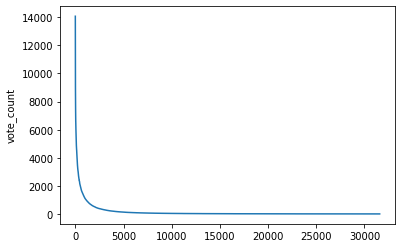

In [2606]:
import seaborn as sns
sns.lineplot(data=smd.sort_values(by=['vote_count'], ascending=False).reset_index()['vote_count']);